# Lecture 2: Introduction to k-Nearest Neighbors

**ECE 2410 - Introduction to Machine Learning**  
**Spring 2026**

---

## Prerequisites

Before starting this notebook, you should have completed the following sections from **HW01: Hello Jupyter**:

| HW01 Section | Topics | Why You Need It |
|--------------|--------|----------------|
| §7 | NumPy arrays, vectors, matrices | We'll work with data as matrices |
| §7.3 | Slicing and indexing | We need to access rows of matrices |
| §8 | Boolean indexing, argmax | We'll find nearest neighbors |

If you haven't completed these exercises, **complete them now** before continuing.

---

In [1]:
NAME = ""
COLLABORATORS = ""

---

## Setup: Import Libraries

In [2]:
from matplotlib import pyplot as plt  # For plotting
import numpy as np  # For numerical arrays and operations

---

# Part 1: Quick Review (from HW01)

Let's quickly verify you're comfortable with the HW01 concepts we'll build on. Run these cells to make sure you understand.

In [3]:
# From HW01 §7: Creating matrices
# Each row is a data point, each column is a feature
data = np.array([[81, 235],   # Player 0: height=81 inches, weight=235 lbs
                 [86, 225],   # Player 1
                 [73, 162],   # Player 2
                 [75, 180]])  # Player 3

print("Data matrix (4 players × 2 features):")
print(data)
print(f"Shape: {data.shape}")

Data matrix (4 players × 2 features):
[[ 81 235]
 [ 86 225]
 [ 73 162]
 [ 75 180]]
Shape: (4, 2)


In [4]:
# From HW01 §7.3: Slicing
print("First row (player 0):", data[0, :])    # All columns of row 0
print("Second column (weights):", data[:, 1])  # All rows of column 1

First row (player 0): [ 81 235]
Second column (weights): [235 225 162 180]


In [5]:
# From HW01 §8: Argmax
weights = data[:, 1]
heaviest_idx = np.argmax(weights)
print(f"Heaviest player is at index {heaviest_idx} with weight {weights[heaviest_idx]} lbs")

Heaviest player is at index 0 with weight 235 lbs


### ✅ Checkpoint

If the above cells made sense, you're ready to continue! If not, go back to HW01 and review those sections.

---

# Part 2: Distance and Norms

For k-Nearest Neighbors, we need to measure how "close" two data points are. This requires computing **distance**.

## 2.1 The Euclidean Distance

The **Euclidean distance** between two points $x$ and $z$ is:

$$d(x, z) = \sqrt{\sum_{j=1}^{d} (x_j - z_j)^2} = \|x - z\|_2$$

This is also called the **L2 norm** of the difference vector.

In [6]:
# Example: Distance between player 0 and player 1
player0 = data[0, :]  # [81, 235]
player1 = data[1, :]  # [86, 225]

# Compute manually using the formula:
# sqrt((81-86)^2 + (235-225)^2) = sqrt(25 + 100) = sqrt(125)
diff = player0 - player1
print(f"Difference vector: {diff}")
print(f"Squared differences: {diff**2}")
print(f"Sum of squared differences: {np.sum(diff**2)}")
print(f"Distance (manual): {np.sqrt(np.sum(diff**2))}")

Difference vector: [-5 10]
Squared differences: [ 25 100]
Sum of squared differences: 125
Distance (manual): 11.180339887498949


## 2.2 Using `np.linalg.norm()`

NumPy provides a built-in function to compute norms efficiently:

In [7]:
# View the documentation
?np.linalg.norm

Signature:       np.linalg.norm(x, ord=None, axis=None, keepdims=False)
Call signature:  np.linalg.norm(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function norm at 0x10e83fc40>
File:            ~/GitHub/Intro2ML_dev/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py
Docstring:      
Matrix or vector norm.

This function is able to return one of eight different matrix norms,
or one of an infinite number of vector norms (described below), depending
on the value of the ``ord`` parameter.

Parameters
----------
x : array_like
    Input array.  If `axis` is None, `x` must be 1-D or 2-D, unless `ord`
    is None. If both `axis` and `ord` are None, the 2-norm of
    ``x.ravel`` will be returned.
ord : {int, float, inf, -inf, 'fro', 'nuc'}, optional
    Order of the norm (see table under ``Notes`` for what values are
    supported for matrices and vectors respectively). inf means numpy's
    `inf` object. The default is None.
axis : {None, int, 2-tuple

In [8]:
# Same calculation using np.linalg.norm
distance = np.linalg.norm(player0 - player1)
print(f"Distance using np.linalg.norm: {distance}")

Distance using np.linalg.norm: 11.180339887498949


### Classic Example: The 3-4-5 Triangle

In [9]:
# The classic right triangle: legs of 3 and 4 → hypotenuse of 5
x = np.array([3, 4])
origin = np.array([0, 0])

# Distance from origin = sqrt(3^2 + 4^2) = sqrt(9 + 16) = sqrt(25) = 5
print(f"Distance from origin: {np.linalg.norm(x - origin)}")
print(f"Or equivalently: {np.linalg.norm(x)}")

Distance from origin: 5.0
Or equivalently: 5.0


## 2.3 Different Distance Metrics

The `ord` parameter in `np.linalg.norm` specifies which norm to use:

| `ord=` | Name | Formula | Use Case |
|--------|------|---------|----------|
| 2 (default) | Euclidean (L2) | $\sqrt{\sum x_j^2}$ | Most common |
| 1 | Manhattan (L1) | $\sum \|x_j\|$ | Grid-like distances |
| np.inf | Max (L∞) | $\max \|x_j\|$ | Maximum coordinate difference |

In [10]:
x = np.array([3, 4])

print(f"L2 (Euclidean) norm: {np.linalg.norm(x, ord=2)}")  # sqrt(9+16) = 5
print(f"L1 (Manhattan) norm: {np.linalg.norm(x, ord=1)}")  # |3| + |4| = 7
print(f"L∞ (Max) norm: {np.linalg.norm(x, ord=np.inf)}")   # max(3, 4) = 4

L2 (Euclidean) norm: 5.0
L1 (Manhattan) norm: 7.0
L∞ (Max) norm: 4.0


---

## 🎯 Activity 1: Computing Distances

Using our basketball player data, compute the Euclidean distance between:
1. Player 0 and Player 2
2. Player 0 and Player 3

Store them in variables `dist_0_2` and `dist_0_3`.

In [11]:
# Data from above
data = np.array([[81, 235],   # Player 0
                 [86, 225],   # Player 1
                 [73, 162],   # Player 2
                 [75, 180]])  # Player 3

print("Player 0:", data[0, :])
print("Player 2:", data[2, :])
print("Player 3:", data[3, :])

Player 0: [ 81 235]
Player 2: [ 73 162]
Player 3: [ 75 180]


In [12]:
### BEGIN SOLUTION
dist_0_2 = np.linalg.norm(data[0,:]-data[2,:])
dist_0_3 = np.linalg.norm(data[0,:]-data[3,:])
### END SOLUTION

In [13]:
"""Check correctness"""
assert np.isclose(dist_0_2, 73.43704984976578), f"dist_0_2 should be ~73.44, got {dist_0_2}"
assert np.isclose(dist_0_3, 55.32630477449222), f"dist_0_3 should be ~55.32, got {dist_0_3}"
print(f"Distance from Player 0 to Player 2: {dist_0_2:.2f}")
print(f"Distance from Player 0 to Player 3: {dist_0_3:.2f}")
print("✓ Activity 1 passed!")

Distance from Player 0 to Player 2: 73.44
Distance from Player 0 to Player 3: 55.33
✓ Activity 1 passed!


---

# Part 3: Towards k-Nearest Neighbors

Now let's use distance to find the **nearest neighbor** of a test point.

## 3.1 The Classification Problem

We have basketball player data with labels:
- Class 0 = Forward (taller, heavier)
- Class 1 = Guard (shorter, lighter)

Given a **new player**, can we predict if they're a Forward or Guard based on their height and weight?

In [14]:
# Training data: players with known positions
train_features = np.array([[81, 235],   # Forward
                           [86, 225],   # Forward
                           [73, 162],   # Guard
                           [75, 180]])  # Guard
train_labels = np.array([0, 0, 1, 1])  # 0=Forward, 1=Guard

# Test data: new players we want to classify
test_features = np.array([[83, 245],   # ?
                          [76, 200],   # ?
                          [81, 197]])  # ?
test_labels = np.array([0, 1, 0])  # True labels (for checking later)

## 3.2 Visualizing the Data

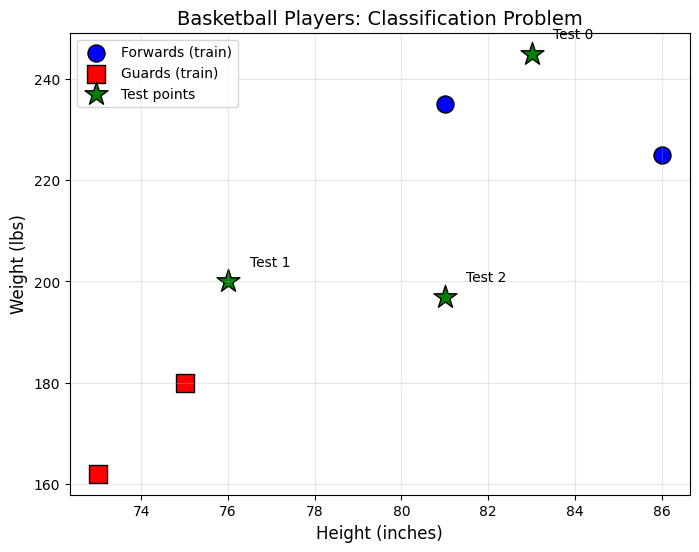

In [15]:
plt.figure(figsize=(8, 6))

# Plot training data
forwards = train_labels == 0
guards = train_labels == 1
plt.scatter(train_features[forwards, 0], train_features[forwards, 1], 
            c='blue', marker='o', s=150, label='Forwards (train)', edgecolors='black')
plt.scatter(train_features[guards, 0], train_features[guards, 1], 
            c='red', marker='s', s=150, label='Guards (train)', edgecolors='black')

# Plot test data
plt.scatter(test_features[:, 0], test_features[:, 1], 
            c='green', marker='*', s=300, label='Test points', edgecolors='black')

# Labels
for i in range(len(test_features)):
    plt.annotate(f'Test {i}', (test_features[i, 0]+0.5, test_features[i, 1]+3))

plt.xlabel('Height (inches)', fontsize=12)
plt.ylabel('Weight (lbs)', fontsize=12)
plt.title('Basketball Players: Classification Problem', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## 🎯 Activity 2: Finding the Nearest Neighbor

For **test point 0** (`test_features[0, :]` = [83, 245]):

1. Compute the distance to **each** training point using a **for loop**
2. Store the distances in the array `distances` (already created)
3. Find the index of the nearest training point using `np.argmin()`
4. Get the label of the nearest neighbor

**Hint:** Review HW01 §4 for for-loop syntax: `for i in range(n):`

In [16]:
# The test point we want to classify
test_point = test_features[0, :]  # [83, 245]
print(f"Test point: {test_point}")

# Number of training points
n_train = train_features.shape[0]

# Initialize array to store distances
distances = np.zeros(n_train)

### BEGIN SOLUTION
for i in range(n_train):
    distances[i] = np.linalg.norm(train_features[i] - test_point)
nearest_idx = np.argmin(distances)
predicted_label = train_labels[nearest_idx]
print(f"Predicted label: {predicted_label} (0 stands for Frwd/Ctr, 1 for Gaurd)")
### END SOLUTION



Test point: [ 83 245]
Predicted label: 0 (0 stands for Frwd/Ctr, 1 for Gaurd)


In [17]:
"""Check correctness"""
expected_distances = np.array([10.198039027185569, 20.22374550327314, 83.60023923205413, 65.49045957240982])
assert np.allclose(distances, expected_distances), f"Distances don't match"
assert nearest_idx == 0, f"Nearest index should be 0, got {nearest_idx}"
assert predicted_label == 0, f"Predicted label should be 0 (Forward), got {predicted_label}"

print(f"Distances to each training point: {np.round(distances, 2)}")
print(f"Nearest training point index: {nearest_idx}")
print(f"Predicted label: {predicted_label} ({'Forward' if predicted_label == 0 else 'Guard'})")
print(f"True label: {test_labels[0]} ({'Forward' if test_labels[0] == 0 else 'Guard'})")
print("✓ Activity 2 passed!")

Distances to each training point: [10.2  20.22 83.6  65.49]
Nearest training point index: 0
Predicted label: 0 (Forward)
True label: 0 (Forward)
✓ Activity 2 passed!


---

## 🎯 Activity 3: Classify All Test Points

Now extend your code to classify **all 3 test points** using 1-Nearest Neighbor.

Use a **nested loop**: outer loop over test points, inner loop over training points.

Store the predicted labels in `predictions`.

In [18]:
n_train = train_features.shape[0]
n_test = test_features.shape[0]

# Array to store predictions
predictions = np.zeros(n_test, dtype=int)

### BEGIN SOLUTION
distances = np.zeros(n_train)
for j in range(n_test):
    test_point = test_features[j]
    for i in range(n_train):
        distances[i] = np.linalg.norm(train_features[i] - test_point)
    nearest_idx = np.argmin(distances)
    predictions[j] = train_labels[nearest_idx]
    print(f"Test point {j} is predicted to be class {predictions[j]}")
### END SOLUTION


Test point 0 is predicted to be class 0
Test point 1 is predicted to be class 1
Test point 2 is predicted to be class 1


In [21]:
"""Check correctness"""
expected_predictions = np.array([0, 1, 1])
# Note: These are the correct 1-NN predictions, not the true labels
assert np.array_equal(predictions, expected_predictions), f"Expected {expected_predictions}, got {predictions}"

print("Results:")
print(f"Test points: {test_features.tolist()}")
print(f"Predictions: {predictions}")
print(f"True labels: {test_labels}")

accuracy = np.mean(predictions == test_labels) * 100
print(f"\nAccuracy: {accuracy:.0f}%")
print("✓ Activity 3 passed!")

Results:
Test points: [[83, 245], [76, 200], [81, 197]]
Predictions: [0 1 1]
True labels: [0 1 0]

Accuracy: 67%
✓ Activity 3 passed!


## Visualizing the Results

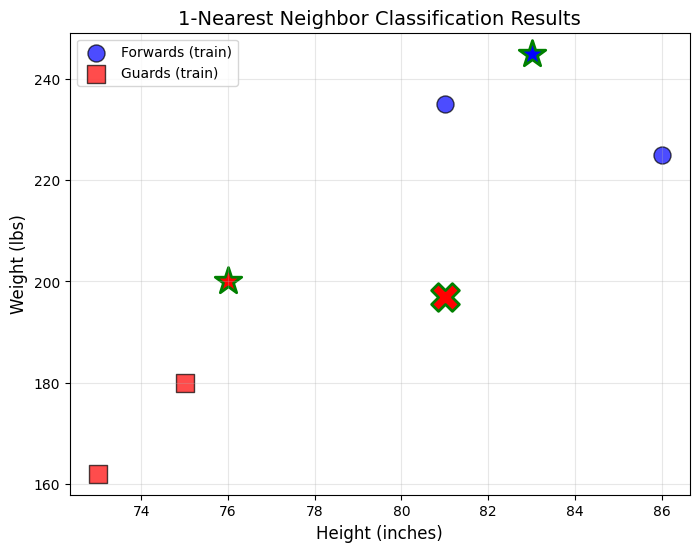

Stars (*) = correct predictions, X = incorrect predictions


In [22]:
plt.figure(figsize=(8, 6))

# Training data
forwards = train_labels == 0
guards = train_labels == 1
plt.scatter(train_features[forwards, 0], train_features[forwards, 1], 
            c='blue', marker='o', s=150, label='Forwards (train)', edgecolors='black', alpha=0.7)
plt.scatter(train_features[guards, 0], train_features[guards, 1], 
            c='red', marker='s', s=150, label='Guards (train)', edgecolors='black', alpha=0.7)

# Test predictions
for i in range(n_test):
    color = 'blue' if predictions[i] == 0 else 'red'
    correct = predictions[i] == test_labels[i]
    marker = '*' if correct else 'X'
    plt.scatter(test_features[i, 0], test_features[i, 1], 
                c=color, marker=marker, s=400, edgecolors='green', linewidths=2)

plt.xlabel('Height (inches)', fontsize=12)
plt.ylabel('Weight (lbs)', fontsize=12)
plt.title('1-Nearest Neighbor Classification Results', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Stars (*) = correct predictions, X = incorrect predictions")

---

# Summary

In this notebook, you learned:

**Building on HW01:**
- Used NumPy array slicing (§7.3) to access rows
- Used `np.argmin()` (§8) to find nearest neighbors

**New Concepts:**
1. **Euclidean Distance**: $d(x, z) = \|x - z\|_2$
2. **`np.linalg.norm()`**: Efficient way to compute distances
3. **1-Nearest Neighbor Algorithm**:
   - Compute distance from test point to all training points
   - Find the training point with minimum distance
   - Copy its label as the prediction

---

**Next lecture:** We'll extend this to **k**-NN (majority voting among k neighbors) and apply it to the full NBA and MNIST datasets!